# Detection of modified images or videos using Neural Networks

## Importing the libraries

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageFilter
import pandas as pd
import os
import io
import shutil
from kaggle.api.kaggle_api_extended import KaggleApi

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, Lambda, Resizing, Rescaling, GlobalAveragePooling2D
from keras.applications import ResNet50, MobileNet, MobileNetV2, VGG16, Xception, EfficientNetB1
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import itertools

K.clear_session()
tf.compat.v1.reset_default_graph()
tf.compat.v1.enable_eager_execution()

## Downloading the dataset

In [39]:
URL = "sophatvathana/casia-dataset"
PATH_DATASET = './../dataset/'

def download_dataset():
    api = KaggleApi()
    api.authenticate()
    print("Downloading files...")
    api.dataset_download_files('sophatvathana/casia-dataset', path=PATH_DATASET, unzip=True)

    print("\rDownload complete.")


def clean_directory():
    print("Moving folder...")
    os.rename(PATH_DATASET+"CASIA2/Au", PATH_DATASET+"Au")
    os.rename(PATH_DATASET+"CASIA2/Tp", PATH_DATASET+"Tp")
    
    print("Cleaning directory...")
    shutil.rmtree(PATH_DATASET+"casia")
    shutil.rmtree(PATH_DATASET+"CASIA1")
    shutil.rmtree(PATH_DATASET+"CASIA2")
    os.remove(PATH_DATASET+"Tp/Thumbs.db")
    os.remove(PATH_DATASET+"Au/Thumbs.db")
    print("Cleaning complete.")

def remove_images():
    print("Removing images...")
    for i in range(1, 4):
        os.remove(PATH_DATASET+"Au/Au ("+str(i)+").jpg")
        os.remove(PATH_DATASET+"Tp/Tp ("+str(i)+").jpg")
    print("Removing complete.")

In [40]:
if not os.path.exists(PATH_DATASET+"Au"):
    download_dataset()
    clean_directory()
else:
    print("Dataset already Downloaded.")

Dataset already Downloaded.


In [41]:
REAL_IMAGE_PATH = '../dataset/Au'
FAKE_IMAGE_PATH = "../dataset/Tp"
IMG_SIZE = (256, 256)
CLASS = ["real", "fake"]

## Loading the dataset

In [42]:
cabezera = "category", "image", "class"
df_au = pd.DataFrame(columns=cabezera)
df_tp = pd.DataFrame(columns=cabezera)

for idx, file in enumerate(os.listdir(REAL_IMAGE_PATH)):
    img_path = os.path.join(REAL_IMAGE_PATH, file)
    category = file.split("_")

    df_au = pd.concat([df_au, pd.DataFrame([[category[1], img_path, CLASS[0]]], columns=cabezera)], ignore_index=True)

for file in os.listdir(FAKE_IMAGE_PATH):
    #convert image to np array
    img_path = os.path.join(FAKE_IMAGE_PATH, file)

    category = file.split("_")
    category[5] = category[5][:3]
    df_tp = pd.concat([df_tp, pd.DataFrame([[category[5], img_path, CLASS[1]]], columns=cabezera)], ignore_index=True)

df = pd.concat([df_au, df_tp], ignore_index=True)
df = df[df.category != "txt"]
df = df[df.category != "ind"]
df = df.sample(frac=1).reset_index(drop=True)

df.head()


,category,image,class
0,sec,../dataset/Tp\Tp_D_NRN_M_N_sec00007_sec00004_1...,fake
1,arc,../dataset/Au\Au_arc_30118.jpg,real
2,sec,../dataset/Au\Au_sec_00042.jpg,real
3,nat,../dataset/Au\Au_nat_30130.jpg,real
4,arc,../dataset/Au\Au_arc_30054.jpg,real


## Creating Preprocessing Function

In [43]:
def ela(image, quality=95):
    # Comprimir y descomprimir la imagen
    _, buffer = cv2.imencode('.jpg', image, [cv2.IMWRITE_JPEG_QUALITY, quality])
    compressed_image = cv2.imdecode(np.frombuffer(buffer, np.uint8), cv2.IMREAD_COLOR)

    #convert compressed_image uint8 to float32
    compressed_image = compressed_image.astype(np.float32)

    diff = 15 * cv2.absdiff(image, compressed_image)
    
    return diff

from keras.applications.efficientnet import preprocess_input

def preprocess_image(image):
    #image = tf.cast(tensor, tf.uint8).numpy()
    image = ela(image)
    #image = preprocess_input(image)
    return tf.convert_to_tensor(image)

def ela_v2(orig_img, quality=95):
    _, buffer = cv2.imencode('.jpg', orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])
    compressed_img = cv2.imdecode(np.frombuffer(buffer, np.uint8), cv2.IMREAD_COLOR)

    orig_img = orig_img.astype(np.uint8)

    diff = 15 * cv2.absdiff(orig_img, compressed_img)
    gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    # Aplicar umbralización para convertir en una imagen binaria
    threshold_value, binary_image = cv2.threshold(gray_diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Multiplicar la imagen binaria por la imagen de diferencia original para resaltar los píxeles falsos
    diff_highlighted = cv2.bitwise_and(diff, diff, mask=binary_image)

    # Aplicar filtrado Gaussiano para reducir el ruido
    diff_filtered = cv2.GaussianBlur(diff_highlighted, (5, 5), 0)

    return diff_filtered

## Creating Model

In [44]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [45]:
batch_size = 32

### Creating and splitting the dataset

In [46]:
# Crear un generador de datos de imágenes con aumentación de datos
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    #rescale=1./255, 
    #rotation_range=20, 
    #width_shift_range=0.2, 
    #height_shift_range=0.2, 
    #shear_range=0.2, 
    #zoom_range=0.2, 
    #horizontal_flip=True, 
    #fill_mode='nearest',
    validation_split=0.2
)

# Crear un generador de datos de imágenes sin aumentación de datos para el conjunto de test
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    #rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col="image",
    y_col="class",
    subset="training",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=IMG_SIZE
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col="image",
    y_col="class",
    subset="validation",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=IMG_SIZE
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=None,
    x_col="image",
    y_col="class",
    batch_size=batch_size,
    shuffle=False,
    class_mode="binary",
    target_size=IMG_SIZE
)

Found 7294 validated image filenames belonging to 2 classes.
Found 1823 validated image filenames belonging to 2 classes.
Found 2280 validated image filenames belonging to 2 classes.


### Creating the checkpoints

In [47]:
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=10, 
    verbose=0, 
    mode='auto', 
    baseline=None, 
    restore_best_weights=False
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)


model_chekpoint = ModelCheckpoint(
    filepath='./../model/checkpoints', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True,
    save_weights_only=True, 
    mode='auto', 
    save_freq='epoch'
)

tensor_board = TensorBoard(
    log_dir='./../model/logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None
)

callbacks = [early_stopping, model_chekpoint, tensor_board]
optimizer = Adam(1e-3)
loss = keras.losses.BinaryCrossentropy()

### Creating the model fron scratch

detect_manipulated_images_model_scratch_v1.h5 8min 31s 12 epocas bacth_size=32

loss: 1.6352 - accuracy: 0.7355 - precision: 0.9418 - recall: 0.3194 - auc: 0.8527 - prc: 0.8239

In [48]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation=None, input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(5, 5), activation=None, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(5, 5), activation=None, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation=None, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 252, 252, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 252, 252, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      51264     
                                                                 
 batch_normalization_1 (Batc  (None, 122, 122, 64)     2

### Creating the model using transfer learning (ResNet50)

detect_manipulated_images_model_resnet50_v1.h5 10m 46s 7 epocas bacth_size=16

loss: 0.4613 - accuracy: 0.8307 - precision: 0.8105 - recall: 0.7201 - auc: 0.9256 - prc: 0.8760



In [49]:
inputs = Input(shape=(256, 256, 3))

model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

x = Flatten()(model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.inputs, outputs=predictions)

### Creating the model using transfer learning (MobileNet)

detect_manipulated_images_model_mobilenet_v4.h5 12min 46s 12 epocas bacth_size=32

loss: 0.7375 - binary_accuracy: 0.9193 - precision: 0.9753 - recall: 0.8889 - auc: 0.9468 - prc: 0.9692

In [50]:
inputs = Input(shape=(256, 256, 3))
model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

x = GlobalAveragePooling2D()(model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.inputs, outputs=predictions)

detect_manipulated_images_model_mobilenet_v2.h5 1min 47s 12 epocas bacth_size=32

loss: 0.5404 - accuracy: 0.7285 - precision: 0.7123 - recall: 0.4715 - auc: 0.7986 - prc: 0.6622

In [51]:
inputs = Input(shape=(256, 256, 3))
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

x = GlobalAveragePooling2D()(model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.inputs, outputs=predictions)

### Creating the model using transfer learning (VGG16)

detect_manipulated_images_model_vgg16_v1.h5 36m 11s 15 epocas bacth_size=32

loss: 0.3823 - accuracy: 0.8662 - precision: 0.8022 - recall: 0.8571 - auc: 0.9345 - prc: 0.8679

In [52]:
# Cargar la arquitectura pre-entrenada VGG-16 sin las capas completamente conectadas
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Definir una nueva capa de salida personalizada
x = vgg16.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Construir el modelo final que incluye VGG-16 y la nueva capa de salida
model = Model(inputs=vgg16.inputs, outputs=predictions)

### Creatin Model Xception

detect_manipulated_images_model_Xception.h5 29m 38s 12 epocas bacth_size=16

loss: 0.5450 - binary_accuracy: 0.8978 - precision: 0.9046 - recall: 0.9300 - auc: 0.9331 - prc: 0.9372

In [53]:
inputs = Input(shape=(256, 256, 3))
model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

x = GlobalAveragePooling2D()(model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.inputs, outputs=predictions)

### Creatin Model EfficientNetB1

detect_manipulated_images_model_EfficientNetB1.h5 31m 38s 14 epocas bacth_size=32

loss: 0.3236 - binary_accuracy: 0.9211 - precision: 0.9309 - recall: 0.9390 - auc: 0.9653 - prc: 0.9708

In [60]:
model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = GlobalAveragePooling2D()(model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.inputs, outputs=predictions)

### Training the model

In [55]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit(train_generator, epochs=50, batch_size=batch_size, validation_data=val_generator, callbacks=callbacks)

Epoch 1/50
228/228 [==============================] - 148s 612ms/step - loss: 0.3383 - binary_accuracy: 0.8534 - precision: 0.8974 - recall: 0.8623 - auc: 0.9264 - prc: 0.9542 - val_loss: 0.3718 - val_binary_accuracy: 0.8678 - val_precision: 0.9077 - val_recall: 0.8689 - val_auc: 0.9432 - val_prc: 0.9555
Epoch 2/50
228/228 [==============================] - 138s 604ms/step - loss: 0.2334 - binary_accuracy: 0.8935 - precision: 0.9487 - recall: 0.8756 - auc: 0.9619 - prc: 0.9780 - val_loss: 0.7341 - val_binary_accuracy: 0.7735 - val_precision: 0.9006 - val_recall: 0.7013 - val_auc: 0.8784 - val_prc: 0.9016
Epoch 3/50
228/228 [==============================] - 137s 602ms/step - loss: 0.1953 - binary_accuracy: 0.9121 - precision: 0.9458 - recall: 0.9105 - auc: 0.9746 - prc: 0.9851 - val_loss: 0.3097 - val_binary_accuracy: 0.9095 - val_precision: 0.9542 - val_recall: 0.8925 - val_auc: 0.9660 - val_prc: 0.9801
Epoch 4/50
228/228 [==============================] - 136s 598ms/step - loss: 0.17

### Evaluating the model

In [56]:
model.evaluate(test_generator)

72/72 [==============================] - 14s 191ms/step - loss: 0.3236 - binary_accuracy: 0.9211 - precision: 0.9309 - recall: 0.9390 - auc: 0.9653 - prc: 0.9708


[0.32356342673301697,
 0.9210526347160339,
 0.9308855533599854,
 0.9389978051185608,
 0.9653269648551941,
 0.9707502722740173]

### Showing the results

In [57]:
def plot_metrics(history):
    metrics = ['binary_accuracy', 'loss', 'prc', 'precision', 'recall']
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 10))
    
    for i, metric in enumerate(metrics):
        axes[i].plot(history.history[metric], label='train')
        axes[i].plot(history.history[f'val_{metric}'], label='val')
        axes[i].set_title(metric)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, X, y_true):
    y_pred = model.predict(X) > 0.5
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, cmap=plt.cm.Reds)
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.xticks([0, 1], ['Manipulated', 'Original'], fontsize=12)
    plt.yticks([0, 1], ['Manipulated', 'Original'], fontsize=12)
    plt.colorbar()
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i][j]), ha='center', va='center', fontsize=20)
    plt.show()

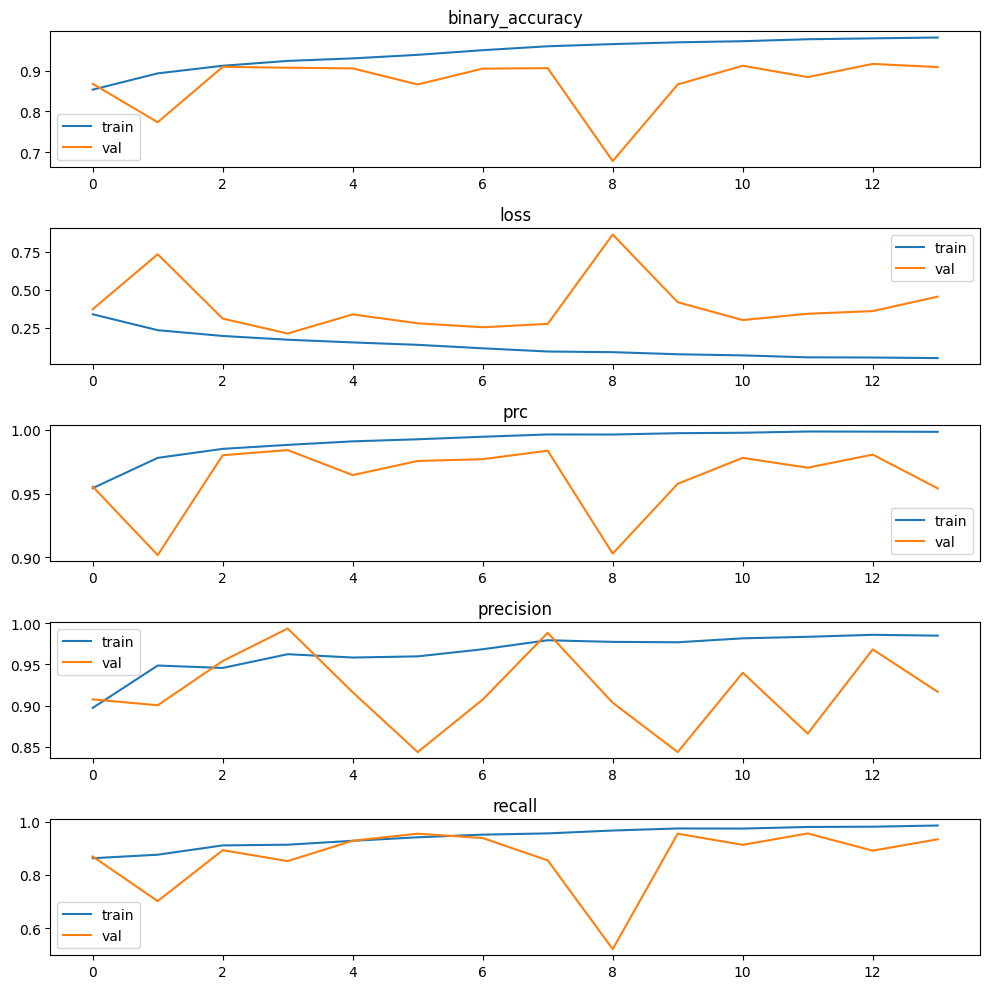

In [58]:
plot_metrics(history)

In [ ]:
#plot_confusion_matrix(model, x_test, y_test)

In [59]:
model.save('./../model/ela_models/detect_manipulated_images_model_EfficientNetB1.h5')

In [2]:
tf.compat.v1.disable_eager_execution()
model = load_model('./../model/ela_models/detect_manipulated_images_model_mobileNet_v3.h5')

Instructions for updating:
Colocations handled automatically by placer.


### Probando modelo con mapa de calor

In [9]:
def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        # Comprobar si la capa es una capa convolucional
        if isinstance(layer, Conv2D):
            return layer
    
    return None

def predict_with_heatmap(model, img_original):
    # Load image and convert to RGB
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    img_original = cv2.resize(img_original, (256, 256))
    img = ela(img_original)
    img = np.expand_dims(img, axis=0)
    
    # Get predictions and last convolutional layer output
    preds = model.predict(img)
    last_conv_layer = get_last_conv_layer(model)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)
    last_conv_output = last_conv_layer_model.predict(img)
    
    # Get class activation map
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.inputs], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, last_conv_output_value = iterate([img])
    for i in range(last_conv_output_value.shape[-1]):
        last_conv_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(last_conv_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    # Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
    
    # Convert heatmap to RGB format
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay heatmap on original image
    superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)
    
    return img_original, superimposed_img, class_idx

def plot_heatmap(img_original, superimposed_img, class_idx):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title('Original image')
    plt.imshow(img_original)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Heatmap')
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()
    
    print('Predicted class:', class_idx)
    print('Predicted class name:', CLASS[class_idx])

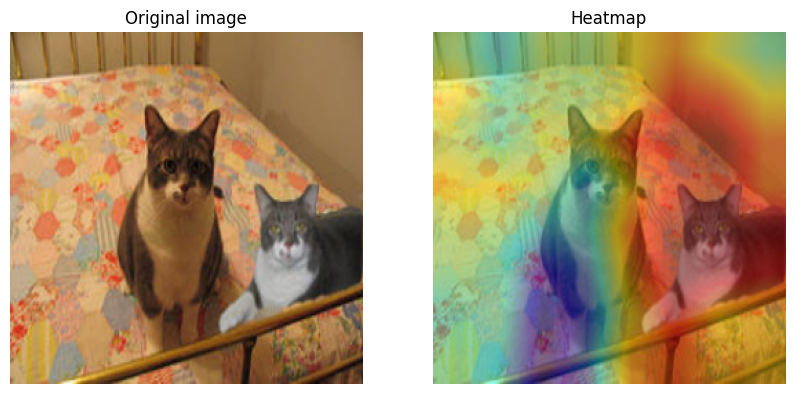

Predicted class: 0


NameError: name 'CLASS' is not defined

In [13]:
tf.compat.v1.disable_eager_execution()
model = load_model('./../model/ela_models/detect_manipulated_images_model_mobileNet_v3.h5')
path = '../dataset/Tp/Tp_D_CRD_S_O_ani10103_ani10111_10637.jpg'
img = cv2.imread(path)

original_img, heatmap_img, result = predict_with_heatmap(model, img)
plot_heatmap(original_img, heatmap_img, result)